Predict rating of a book for a user

6500 books (after filtr.), 11000 users, 320K ratings, of which 111K explicit

nebo < 2OO ratings per user filter
- 224K total ratings, of which 91K explicit ratings
    - otazka jak vypada histogram explicit ratings per book/user

ratings - málo, protože implicit musim ignorovat
- mozna by šlo self training na implicit ratings?
    - dost prace, takze ted ne


In [1]:
from pathlib import Path
from dataset import read_bx_csv

data_root = Path('data/BX-CSV-Dump')
users = read_bx_csv(data_root / 'BX-Users.csv')
books = read_bx_csv(data_root / 'BX-Books.csv')
ratings = read_bx_csv(data_root / 'BX-Book-Ratings.csv')

2023-09-24 22:05:35.341650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# create wide form of ratings
ratings_wide = ratings.merge(books, on='ISBN').merge(users, on='User-ID').drop(columns=[f'Image-URL-{size}' for size in 'SML'])
ratings_wide.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"cincinnati, ohio, usa",23.0
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,"cincinnati, ohio, usa",23.0
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,"cincinnati, ohio, usa",23.0
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,"cincinnati, ohio, usa",23.0


In [3]:
from dataset import filter_ratings
f_ratings_wide = filter_ratings(ratings_wide, user_ratings_max_count=200)

In [4]:
# clip user age to 100
f_ratings_wide['Age'] = f_ratings_wide['Age'].clip(upper=100)

<Axes: >

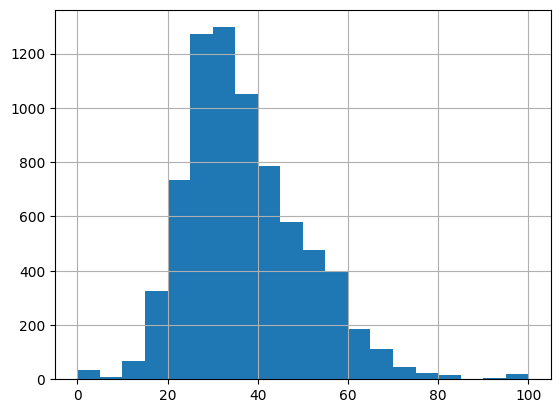

In [5]:
# aggregate users from filtered ratings
f_users = f_ratings_wide.groupby('User-ID').first().reset_index()
f_users.Age.hist(bins=20)

In [6]:
# replace n/a in user age with -100 (for bucketing to onehot - unknown age will get its own category)
f_ratings_wide['Age'] = f_ratings_wide['Age'].fillna(-100)

<Axes: >

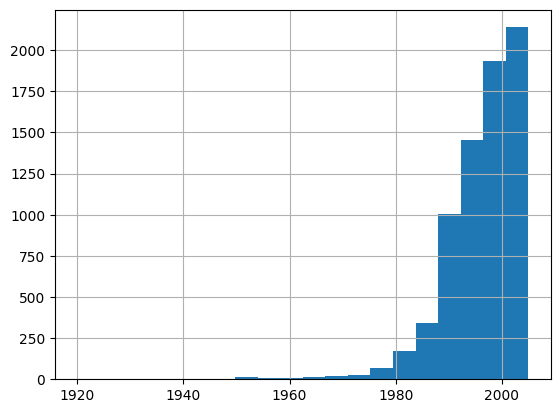

In [7]:
# aggregate books from filtered ratings
f_books = f_ratings_wide.groupby('ISBN').first().reset_index()
f_books[f_books['Year-Of-Publication'] > 0]['Year-Of-Publication'].hist(bins=20)

In [8]:
f_ratings_wide.isna().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Location               0
Age                    0
book_ratings_count     0
user_ratings_count     0
dtype: int64

In [9]:
import numpy as np

In [10]:
%load_ext autoreload
%autoreload complete --print

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from statistics import LinearRegression
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd

from hash_transform import HashingTransformer

In [11]:

# todo fix Location
#   that really could be important, esp. if people cannot read in all languages in the dataset
categoricals = ['Book-Author', 'Publisher'] #'Location']

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), categoricals),
    ('bucketize_yop', KBinsDiscretizer(n_bins=12, strategy='kmeans'), ['Year-Of-Publication']),
    ('bucketize_age', KBinsDiscretizer(n_bins=10), ['Age']),
    ('hash', HashingTransformer(bit_size=128), ['User-ID', 'ISBN']),
], remainder='drop')

X = preprocessor.fit_transform(f_ratings_wide)
y = f_ratings_wide['Book-Rating']

# # Define and fit pipeline
# pipeline = Pipeline([
#     ('hashing', HashingTransformer(bit_size=128), ['User-ID', 'ISBN']),
#     ('linear_reg', Ridge())
# ])

/Users/adam/venvs/datasentics-uloha/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/adam/venvs/datasentics-uloha/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [12]:
ridge = Ridge()

print("Performing grid search...")
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
}

grid_search = GridSearchCV(ridge, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X, y)


Performing grid search...


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0, 100.0]})

In [13]:
grid_search.cv_results_


{'mean_fit_time': array([198.92492089,  93.75545673,  42.96543546,  17.61922297]),
 'std_fit_time': array([25.98663461,  8.80900556,  2.39937238,  4.1629966 ]),
 'mean_score_time': array([0.29619703, 0.10488162, 0.07059917, 0.05615077]),
 'std_score_time': array([0.14570728, 0.03709257, 0.02615292, 0.02646119]),
 'param_alpha': masked_array(data=[0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1}, {'alpha': 1.0}, {'alpha': 10.0}, {'alpha': 100.0}],
 'split0_test_score': array([-0.02472927, -0.02241322, -0.01471337, -0.01051135]),
 'split1_test_score': array([0.00496199, 0.00670269, 0.01234487, 0.01424666]),
 'split2_test_score': array([0.00159485, 0.0028877 , 0.00724034, 0.00857082]),
 'split3_test_score': array([0.00120137, 0.00252854, 0.00699012, 0.0073255 ]),
 'split4_test_score': array([-0.04452817, -0.04198559, -0.03534115, -0.03047344]),
 'mean_test_score': array([-0.01229985, -0.

In [14]:
print(grid_search.scorer_)

In [15]:
from sklearn.model_selection import train_test_split
# compute mean squared error on test set
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

best_estimator = grid_search.best_estimator_
best_estimator.fit(X_train, y_train)

y_pred = best_estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}', f'MSE: {mse}', sep='\n')

RMSE: 3.917100765325795
MSE: 15.34367840571593


In [16]:
# without hashing features (just onehot)
preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), categoricals + ['User-ID', 'ISBN']),
    ('bucketize_yop', KBinsDiscretizer(n_bins=12, strategy='kmeans'), ['Year-Of-Publication']),
    ('bucketize_age', KBinsDiscretizer(n_bins=10), ['Age']),
], remainder='drop')

X = preprocessor.fit_transform(f_ratings_wide)

grid_search = GridSearchCV(Ridge(), param_grid, cv=5, n_jobs=-1)
print("Performing grid search...")
grid_search.fit(X, y)


/Users/adam/venvs/datasentics-uloha/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/adam/venvs/datasentics-uloha/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Performing grid search...


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0, 100.0]})

In [17]:
grid_search.cv_results_

{'mean_fit_time': array([5.82417822, 3.9753952 , 2.9117506 , 1.16111445]),
 'std_fit_time': array([0.94362926, 0.5762366 , 0.13482262, 0.29931528]),
 'mean_score_time': array([0.00446558, 0.00706768, 0.03915839, 0.00541525]),
 'std_score_time': array([0.00073516, 0.00206455, 0.03887303, 0.001341  ]),
 'param_alpha': masked_array(data=[0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1}, {'alpha': 1.0}, {'alpha': 10.0}, {'alpha': 100.0}],
 'split0_test_score': array([-0.07975125, -0.07393874, -0.0454457 , -0.01053659]),
 'split1_test_score': array([-0.04732484, -0.04166556, -0.01563679,  0.01274739]),
 'split2_test_score': array([-0.039297  , -0.03368413, -0.00859646,  0.01540771]),
 'split3_test_score': array([-0.00107821,  0.00289856,  0.01836032,  0.02377706]),
 'split4_test_score': array([-0.01844309, -0.01405136, -0.00270735, -0.00791319]),
 'mean_test_score': array([-0.03717888, -0.

In [18]:
from sklearn.pipeline import FeatureUnion
# add product of user and book features to the model (polynomial features)
# (that is all columns excl the `categoricals`)
from sklearn.preprocessing import PolynomialFeatures
# use column transformer to select only the non-categorical columns

# pol

to_poly = ColumnTransformer(transformers=[
    # ('onehot', OneHotEncoder(), categoricals),
    ('bucketize_yop', KBinsDiscretizer(n_bins=7, strategy='kmeans'), ['Year-Of-Publication']),
    ('bucketize_age', KBinsDiscretizer(n_bins=7), ['Age']),
    ('hash', HashingTransformer(bit_size=20), ['User-ID', 'ISBN']),
], remainder='drop')

poly_preprocessor = FeatureUnion([
    ('poly', Pipeline([
        ('to_poly', to_poly),
        ('poly', PolynomialFeatures(degree=2)),
    ])),
    ('other_categorical', ColumnTransformer(transformers=[
        ('onehot', OneHotEncoder(), categoricals),
    ], remainder='drop')),
])

print('X shape before:', X.shape)
X_poly = poly_preprocessor.fit_transform(f_ratings_wide)
print('X shape after:', X_poly.shape)


X shape before: (224170, 20863)


/Users/adam/venvs/datasentics-uloha/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/adam/venvs/datasentics-uloha/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


X shape after: (224170, 4326)


In [19]:
from sklearn.model_selection import train_test_split

# do ridge regression on the polynomial features
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2)
ridge = Ridge()
ridge.fit(X_train, y_train)

# evaluate (R^2 and RMSE)
y_pred = ridge.predict(X_test)

In [36]:

mse = mean_squared_error(y_test, y_pred)
# square root of mse
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}', f'MSE: {mse}', sep='\n')
# R^2
print(f'R^2: {ridge.score(X_test, y_test)}')


RMSE: 3.9116508407083175
MSE: 15.301012299614086
R^2: 0.03237018494829058


# SVR

as the linear regression is not working well, and getting polynomial features is not feasible (even for the hashing method)

In [ ]:
from sklearn.svm import SVR

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), categoricals + ['User-ID', 'ISBN']),
    ('bucketize_yop', KBinsDiscretizer(n_bins=12, strategy='kmeans'), ['Year-Of-Publication']),
    ('bucketize_age', KBinsDiscretizer(n_bins=10), ['Age']),
    # ('hash', HashingTransformer(bit_size=128), ['User-ID', 'ISBN']),
], remainder='drop')

X = preprocessor.fit_transform(f_ratings_wide)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svr = SVR(epsilon=1, verbose=2)
svr.fit(X_train, y_train)

# evaluate (R^2 and RMSE)
y_pred = svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
# square root of mse
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}', f'MSE: {mse}', sep='\n')
# R^2
print(f'R^2: {svr.score(X_test, y_test)}')

